In [2]:
import pandas as pd
import numpy as np
from numpy import dstack
import logging
import itertools
import os
import gensim
import nltk
import re

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import tensorflow as tf
from tensorflow import keras
from keras import utils
from keras.utils import to_categorical
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Activation, Dropout, Input
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text, sequence

from nltk.corpus import stopwords



tf.test.gpu_device_name()

Using TensorFlow backend.


''

In [3]:
mobile = pd.read_csv("Mobile_shuffled.csv")
mobile.head()

,Unnamed: 0,itemid,title,Category,image_path
0,0,963897428,whatsapp 085243112445 iphone 6s 64gb space gray,31,mobile_image/157e7efcbd6e8ddd6d9ad72403a9dbeb.jpg
1,1,991263509,promo order whatsapp o82190534166 samsung gala...,35,mobile_image/d5a1ef12db05670494e75f36dce5ca53.jpg
2,2,1142608316,wa 085399992662 j1 j100 samsung galaxy minus,34,mobile_image/c78a8b35dea1948e2d4ffabcad13819e.jpg
3,3,129945281,iphone 5c 32gb ori bm,31,mobile_image/d52b7e69db53807804e60ef6ed1e51d5.jpg
4,4,1186251722,discon charger asus zenfone 2 a original 100 a...,43,mobile_image/513d26725085cc5b074f53c1eca83517.jpg


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 128264 samples, validate on 32066 samples
Epoch 1/20
128264/128264 [==============================] - 16s 127us/step - loss: 1.2742 - acc: 0.6476 - val_loss: 0.8482 - val_acc: 0.7650
Epoch 2/20
128264/128264 [==============================] - 17s 130us/step - loss: 0.8079 - acc: 0.7745 - val_loss: 0.7480 - val_acc: 0.7871
Epoch 3/20
128264/128264 [==============================] - 17s 130us/step - loss: 0.7187 - acc: 0.7943 - val_loss: 0.6994 - val_acc: 0.7936
Epoch 4/20
128264/128264 [==============================] - 16s 128us/step - loss: 0.6742 - acc: 0.8021 - val_loss: 0.6835 - val_acc: 0.7990
Epoch 5/20
128264/128264 [==============================] - 17s 129us/step - loss: 0.6441 - acc: 0.8089 - val_loss: 0.6697 - val_acc: 0.8013
Epoch 6/2

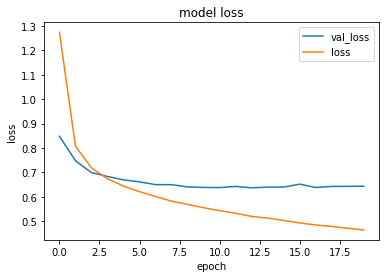

In [4]:
max_words = 1000
batch_size = 3000
epochs = 20


train_size = int(len(mobile) * 0.8) 
train_title = mobile['title'][:train_size] #Takes 70% of the training data to train
train_Category = mobile['Category'][:train_size] #Takes 70% of the training data to train

eval_title = mobile['title'][train_size:] #Takes remaining 30% of the training data to test
eval_Category = mobile['Category'][train_size:] #Takes remaining 30% of the training data to test

tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_title) # only fit on train

x_train = tokenize.texts_to_matrix(train_title)
x_eval = tokenize.texts_to_matrix(eval_title)

encoder = LabelEncoder()
encoder.fit(train_Category)
y_train = train_Category
y_eval = eval_Category
y_train = encoder.transform(train_Category)
y_eval = encoder.transform(eval_Category)

num_classes = np.max(y_train) - np.min(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)   # one hot encode the class values
y_eval = utils.to_categorical(y_eval, num_classes)


# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adagrad',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    validation_data=[x_eval, y_eval],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

def display_training_graph(history):
    # summarize history for loss
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.draw()


display_training_graph(history)

In [5]:
score = model.evaluate(x_eval, y_eval,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

32066/32066 [==============================] - 1s 29us/step
Test accuracy: 0.8149441792470788


In [6]:
filename = './mobile_models/' + 'model_' + str(1) + '.h5'
model.save(filename)
print('>Saved %s' % filename)

>Saved ./mobile_models/model_1.h5
